In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from scipy.misc import imread,imsave
from PIL import Image
import tensorflow as tf
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.models import Model
from keras.layers import Input
import keras.backend as K
import tempfile

import h5py
#sess = tf.Session()
%matplotlib inline

In [8]:
content_image_path = 'content.jpeg'
style_image_path = 'style.jpeg'
alpha = 1e-1
beta = 1
tv = 1e-4

In [9]:

class vgg():
    def __init__(self,input_tensor=None):
        self._build_graph(input_tensor)


    def _build_graph(self,input_tensor):
        with tf.Session() as sess:
            self.input_tensor = input_tensor
            self.model = VGG19(weights='imagenet',include_top=False, input_tensor= self.input_tensor)
            self.outputs = {layer.name : layer.output for layer in self.model.layers}
            self.vgg_weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        
            with tempfile.NamedTemporaryFile() as f:
                self.tf_checkpoint_path = tf.train.Saver(self.vgg_weights).save(sess, f.name)

        self.model_weights_tensors = set(self.vgg_weights)
    
    def load_weights(self):
        sess = tf.get_default_session()
        tf.train.Saver(self.vgg_weights).restore(sess,self.tf_checkpoint_path)
    
    def __getitem__(self, key):
        return self.outputs[key]    



In [10]:
def content_loss(content,generated):
    H,W,C = generated.get_shape().as_list()
    return tf.reduce_sum(tf.squared_difference(content,generated))/(4*H*W*C)

def style_layer_loss(style,generated):
    
    H,W,C = style.get_shape().as_list()
    S = tf.reshape(style,[H*W,C])
    G = tf.reshape(generated,[H*W,C])
    
    GS = tf.matmul(tf.transpose(S),S)
    GG = tf.matmul(tf.transpose(G),G)
    
    return tf.reduce_sum(tf.squared_difference(GG,GS))/(4*np.square(H*W*C))



def style_loss(style_features,gen_image_features,Style_layer):
    cost = 0 
    for key,val in Style_layer.iteritems():
        
        a_S = style_features[key]
        
        a_G = gen_image_features[key]
        
        cost += val*style_layer_loss(a_S,a_G)
    
    return cost

def total_variation_loss(x):
    a = tf.square(x[:, :223, :223, :] - x[:, 1:, :223, :])
    b = tf.square(x[:, :223, :223, :] - x[:, :223, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

def total_loss(content_loss,style_loss,variation_loss,alpha=1e-3,beta=1,tv =1e-6 ):
    return content_loss*alpha + beta*style_loss + tv*variation_loss

def deprocess_image(x, img_nrows, img_ncols):
    if K.image_dim_ordering() == 'th':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
# Remove zero-center by mean pixel
        x[:, :, 0] += 103.939
        x[:, :, 1] += 116.779
        x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
        x = x[:, :, ::-1]
        x = np.clip(x, 0, 255).astype('uint8')
        #scipy.misc.imsave(path, x)
    return x

<tf.Variable 'Variable:0' shape=(1, 224, 224, 3) dtype=float32_ref>

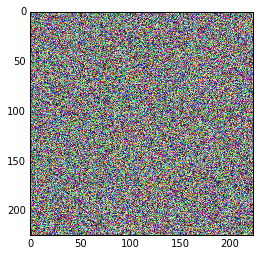

In [11]:
#tf.reset_default_graph()

base_img = image.load_img(content_image_path, target_size=(224, 224))
base_img = image.img_to_array(base_img)
base_img = preprocess_input(np.expand_dims(base_img, axis=0))

imshow(base_img[0])
content = tf.constant(base_img,tf.float32)

style_img = image.load_img(style_image_path,target_size=(224, 224))
style_img = image.img_to_array(style_img)
style_img = preprocess_input(np.expand_dims(style_img, axis=0))
#imshow(style_img[0])
style = tf.constant(style_img,tf.float32)

noise_image = np.random.uniform(-20, 20, (1, 224, 224, 3)).astype('float32')
noise_image = noise_image * 0.6 + base_img * 0.4
imshow(noise_image[0])


Style_layer = {
    'block1_conv1': 0.2,
    'block2_conv1': 0.2,
    'block3_conv1': 0.2,
    'block4_conv1': 0.2,
    'block5_conv1': 0.2}
gen_image = tf.Variable(noise_image)
gen_image 






In [12]:
input_tensor = tf.concat([content,style,gen_image],axis=0)

M1 = vgg(input_tensor=input_tensor)




In [13]:
content_features = M1['block4_conv2'][0]
style_features = {x:M1[x][1] for x in Style_layer}
gen_image_features = {x:M1[x][2] for x in Style_layer}
gen_image_features['block4_conv2'] = M1['block4_conv2'][2]
gen_image_features

{'block1_conv1': <tf.Tensor 'strided_slice_7:0' shape=(224, 224, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'strided_slice_9:0' shape=(112, 112, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'strided_slice_6:0' shape=(56, 56, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'strided_slice_8:0' shape=(28, 28, 512) dtype=float32>,
 'block4_conv2': <tf.Tensor 'strided_slice_11:0' shape=(28, 28, 512) dtype=float32>,
 'block5_conv1': <tf.Tensor 'strided_slice_10:0' shape=(14, 14, 512) dtype=float32>}

In [14]:

content_cost = content_loss(content_features,gen_image_features['block4_conv2'])


style_cost = style_loss(style_features,gen_image_features,Style_layer)
variation_cost = total_variation_loss(gen_image)

total_cost =  total_loss(content_cost,style_cost,variation_cost,alpha,beta,tv)


train = tf.train.AdamOptimizer(learning_rate=5).minimize(total_cost,var_list = [gen_image])


In [15]:
with tf.Session() as sess:
    iterations = 500
    sess.run(tf.global_variables_initializer())
    M1.load_weights()
    for i in range(iterations):
        
        #print(M1.model.get_layer('block4_conv2').get_weights()[0].mean())
        _,loss,output,J_style,J_content,J_var = sess.run([train,total_cost,gen_image,style_cost,content_cost,variation_cost])
        fname = 'output/output_after_iteration '+ str(i)+ '.png'
        out_img = deprocess_image(output,224,224)
        if i%2==0:imsave(fname,out_img)
        if i%2 == 0: print(i,loss,J_style,J_content,J_var)    

INFO:tensorflow:Restoring parameters from /tmp/tmp1aSy8g
(0, 6.8731372e+09, 6.8731064e+09, 81990.367, 2.2275443e+08)
(2, 1.9350984e+09, 1.9350455e+09, 100574.39, 4.2760282e+08)
(4, 9.8009907e+08, 9.8001325e+08, 113174.89, 7.4512192e+08)
(6, 7.2541011e+08, 7.2529523e+08, 120801.29, 1.0275947e+09)
(8, 5.1992314e+08, 5.1978474e+08, 133217.55, 1.2508594e+09)
(10, 4.0919869e+08, 4.090424e+08, 139660.55, 1.4235159e+09)
(12, 3.2551258e+08, 3.2534205e+08, 144387.81, 1.5611095e+09)
(14, 2.6884394e+08, 2.686615e+08, 149274.61, 1.675073e+09)
(16, 2.2464141e+08, 2.2444968e+08, 151915.95, 1.7653665e+09)
(18, 1.935281e+08, 1.9332906e+08, 153724.38, 1.8366141e+09)
(20, 1.719129e+08, 1.7170792e+08, 155660.45, 1.8941027e+09)
(22, 1.5379168e+08, 1.5358221e+08, 156278.69, 1.9383683e+09)
(24, 1.37848e+08, 1.3763509e+08, 157168.28, 1.9720305e+09)
(26, 1.235541e+08, 1.2333855e+08, 159020.19, 1.9964452e+09)
(28, 1.1156904e+08, 1.1135201e+08, 159477.3, 2.0108965e+09)
(30, 1.0271514e+08, 1.024971e+08, 159551.4

(290, 11931589.0, 11760356.0, 178046.48, 1.5342764e+09)
(292, 12205898.0, 12034919.0, 177775.55, 1.5320077e+09)
(294, 12038609.0, 11867562.0, 178415.92, 1.532054e+09)
(296, 11768638.0, 11597788.0, 178327.22, 1.5301737e+09)
(298, 11937452.0, 11766867.0, 178002.28, 1.5278506e+09)
(300, 11662449.0, 11491880.0, 178402.0, 1.5272923e+09)
(302, 11676084.0, 11505617.0, 178597.39, 1.5260714e+09)
(304, 11588340.0, 11418119.0, 178329.42, 1.5238812e+09)
(306, 11497726.0, 11327632.0, 178379.95, 1.5225569e+09)
(308, 11462229.0, 11292183.0, 178700.66, 1.5217582e+09)
(310, 11374291.0, 11204390.0, 178744.05, 1.5202682e+09)
(312, 11325294.0, 11155588.0, 178573.81, 1.5184891e+09)
(314, 11269897.0, 11100318.0, 178613.0, 1.517184e+09)
(316, 11191048.0, 11021542.0, 178852.41, 1.5162143e+09)
(318, 11171530.0, 11002133.0, 178969.69, 1.5149974e+09)
(320, 11075968.0, 10906727.0, 178902.27, 1.5135096e+09)
(322, 11052264.0, 10883177.0, 178840.86, 1.5120302e+09)
(324, 10996849.0, 10827882.0, 178914.78, 1.5107571e+

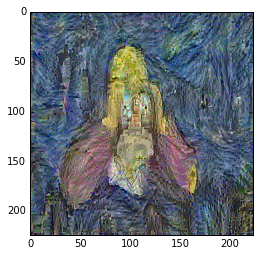

In [16]:
imshow(out_img)

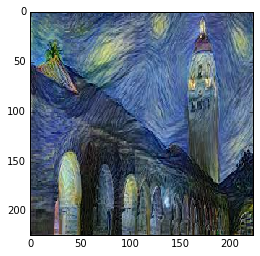

In [17]:
imshow(deprocess_image(style_img,224,224))